# Implementation of KNN and it's aproximations

In this question you will implement and compare the following different KNN variants (see: https://youtu.be/C9HQLyXwEw0?t=3382)
- LSH (1 marks)
- KD-tree (1 marks)
- Naive version of KNN (0.5 marks)

Vary dataset size $N$, number of dimensions $D$ to do training and testing time and memory comparison for finding $K$ nearest neighbours. (1 mark)
Now, in a 2d randomly generated dataset visually show how many of the $K$ closest neighbors appx. $K$ NN methods miss out due to their approximate nature. 

Also show the partitions in the 2d space. (0.5 marks)

## Imports

In [19]:
import time
import tracemalloc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

## Kd-tree

### Implementation

First when the tree is created, we need to sort the data in each node based on the dimension of the node. The dimention can be chosen using various methods like random, cyclic, but in this case we choose it base on the variance. Then we need to split the data in the middle and create two new nodes. We will continue this process until we reach the leaf nodes (number of data point in this node is more than the leaf_size). 

For querying, we follow a process similar to decision trees, we start at the root and based on the query point we decide which child to go to. We continue this process until we reach a node which does not have any children or the number of data points in the child is less than k.

In [ ]:
class Node:
    def __init__(self, data, axis, split_point, lc, rc):
        self.data = data
        self.axis = axis
        self.lc = lc
        self.rc = rc
        self.split_point = split_point

class KDTree:
	def __init__(self, data, leaf_size=2):
		_data = np.concatenate([data, np.arange(data.shape[0]).reshape(-1, 1)], axis=1)
		self.data = _data
		self.leaf_size = leaf_size
		self.tree = self.build_tree(_data)
  
	def build_tree(self, data, depth=0):
		if data.shape[0] <= self.leaf_size:
			return Node(data, -1, None, None, None)
		else:
			axis = np.argmax(np.var(data, axis=0)[:-1]) # remove the index col
			data = data[data[:, axis].argsort()]
			median = data.shape[0] // 2
			return Node(data, axis, data[median], 
               			self.build_tree(data[:median], depth + 1), 
                  		self.build_tree(data[median:], depth + 1))
	
	def query(self, x, k=1):
		return self.query_dfs(self.tree, x, k)

	def query_dfs(self, node, q, k):
		if node is None:
			assert False
			return np.array([]), np.array([])
     
		if node.data.shape[0] <= k or node.axis == -1:
			res = np.concatenate([np.linalg.norm(node.data[:, :-1] - q, axis=1).reshape(-1, 1), 
                         			node.data[:, -1].reshape(-1, 1)], axis=1)
			res.sort(axis=0)
			return res[:k, 0], res[:k, 1]

		if q[node.axis] <= node.split_point[node.axis]:
			if node.lc.data.shape[0] < k:
				res = np.concatenate([np.linalg.norm(node.data[:, :-1] - q, axis=1).reshape(-1, 1), 
                          				node.data[:, -1].reshape(-1, 1)], axis=1)
				res.sort(axis=0)
				return res[:k, 0], res[:k, 1]
			else:
				return self.query_dfs(node.lc, q, k)
		else:
			if node.rc.data.shape[0] < k:
				res = np.concatenate([np.linalg.norm(node.data[:, :-1] - q, axis=1).reshape(-1, 1), 
                          				node.data[:, -1].reshape(-1, 1)], axis=1)
				res.sort(axis=0)
				return res[:k, 0], res[:k, 1]
			else:
				return self.query_dfs(node.rc, q, k)


### Visualisation

We plot the decision boundaries of the kd-tree using a simple dfs while keeping track of the range of values for each node. However this will only work for 2d data. We also progressively decrease the opacity of the line as we go deeper into the tree.

In [21]:
def visualize_kdtree(tree, data, q, k, **kwargs):
	plt.figure(figsize=(7, 7))
	plt.title('KDTree Visualisation')
	plt.xlabel('Feature 1')
	plt.ylabel('Feature 2')
	plt.xlim(0, 100)
	plt.ylim(0, 100)
	plt.grid(True)
	plt.scatter(data[:, 0], data[:, 1], label='Data points')
	plt.scatter(q[0], q[1], color='red', label='Query Point', edgecolor='k', s=100, marker='X')
	dist, idx = tree.query(q, k)
	plt.scatter(data[idx.astype(int), 0], 
				data[idx.astype(int), 1], c='g', label='Nearest points')
	visualize_kdtree_dfs(tree.tree, **kwargs)
	plt.legend()

def visualize_kdtree_dfs(tree, range_x=[0, 100], range_y=[0, 100], depth=0, a=0.4):
	if tree is None:
		return

	range_x_lc = range_x
	range_x_rc = range_x
	range_y_lc = range_y
	range_y_rc = range_y

	if tree.axis == 0:
		plt.plot([tree.split_point[0], tree.split_point[0]], range_y, 'r-', alpha=(a)**depth, label='Split lines' if depth == 0 else "")
		range_x_lc = [range_x[0], tree.split_point[0]]
		range_x_rc = [tree.split_point[0], range_x[1]]
	elif tree.axis == 1:
		plt.plot(range_x, [tree.split_point[1], tree.split_point[1]], 'r-', alpha=(a)**depth, label='Split lines' if depth == 0 else "")
		range_y_lc = [range_y[0], tree.split_point[1]]
		range_y_rc = [tree.split_point[1], range_y[1]]
  
	visualize_kdtree_dfs(tree.lc, range_x_lc, range_y_lc, depth=depth+1, a=a)
	visualize_kdtree_dfs(tree.rc, range_x_rc, range_y_rc, depth=depth+1, a=a)

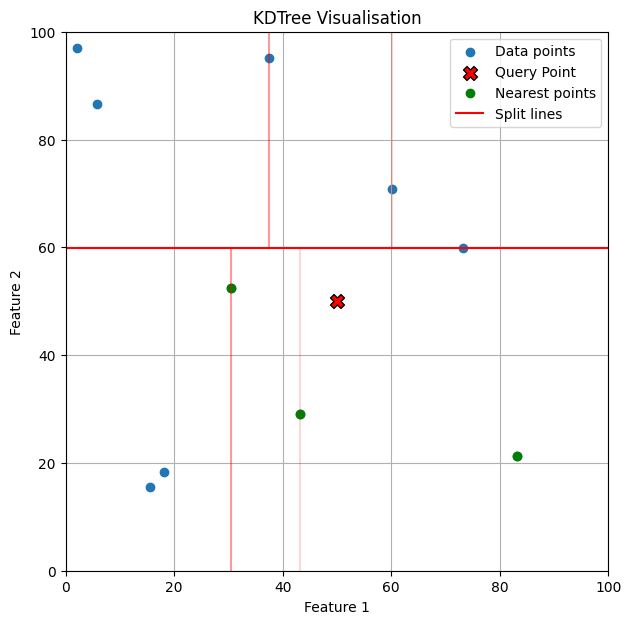

In [22]:
np.random.seed(42)
data = np.random.rand(10, 2) * 100
kdtree = KDTree(data, leaf_size=2) 
visualize_kdtree(kdtree, data, np.array([50, 50]), 3)

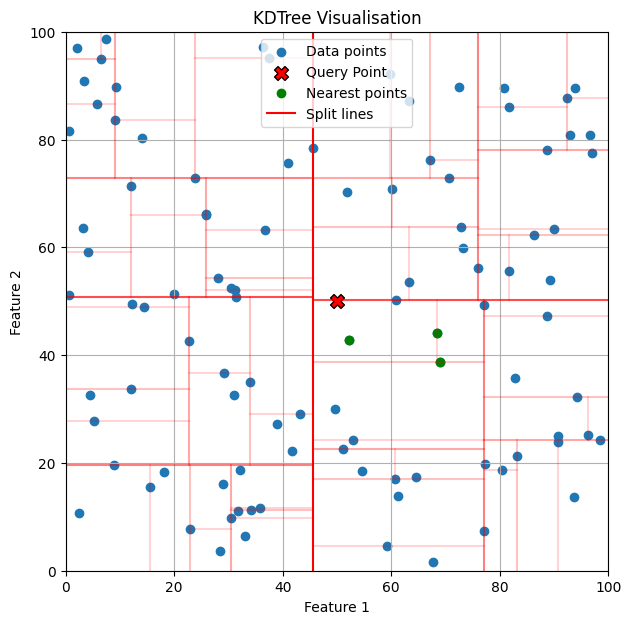

In [23]:
np.random.seed(42)
data = np.random.rand(100, 2) * 100
kdtree = KDTree(data, leaf_size=2)
q = np.array([50, 50])
k = 3
visualize_kdtree(kdtree, data, q, k, a=0.7)

## Locality Sensitive Hashing (LSH)

### Implementation

First we randomly generate num_proj planes (each plane is a random vector) and then we calculate the hash for each data point by taking the sign of the dot product of the data point and the plane. We then create a hash table with the hash as the key and the data point as the value.

For querying, we calculate the hash of the query point and then we search the hash table for the hash, and apply simple KNN on the given cluster.

In [24]:
class LSH:
	def __init__(self, data, num_proj=10):
		self.data = np.concatenate([np.ones(data.shape[0]).reshape(-1, 1), data], axis=1)
		self.num_proj = num_proj
		self.proj = np.random.rand(num_proj, self.data.shape[1]) * 2 - 1
		self.hashes = self.get_hash(self.data)
		self.clusters = {}

		for i in range(self.data.shape[0]):
			hash = self.hashes[i].tobytes()
			if hash not in self.clusters:
				self.clusters[hash] = []
			self.clusters[hash].append(np.concatenate([self.data[i], [i]]))

		for key, val in self.clusters.items():
			self.clusters[key] = np.array(val)
  
	def get_hash(self, data):
		hash = []
		for i in range(self.num_proj):
			proj = self.proj[i]
			proj_data = np.dot(data, proj)
			hash.append(proj_data > 0)
		return np.array(hash).T
	
	def query(self, x, k=1):
		hash = self.get_hash(np.concatenate([np.ones(1).reshape(-1, 1), x.reshape(1, -1)], axis=1))[0]

		if hash.tobytes() in self.clusters:
			cluster = np.array(self.clusters[hash.tobytes()])
			dist = np.linalg.norm(cluster[:, 1:-1] - x, axis=1)
			idx = np.argsort(dist)
			return dist[idx[:min(k, len(dist))]], cluster[idx[:min(k, len(dist))], -1]

### Visualisation

In [25]:
def visualize_kdtree(model, data, q, k):
	plt.figure(figsize=(7, 7))
	plt.scatter(q[0], q[1], color='red', label='Query Point', edgecolor='k', s=100, marker='X')

	colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
	for i, (_, vec) in enumerate(model.clusters.items()):
		color = colours[i % len(colours)]
		plt.scatter(vec[:, 1], vec[:, 2], color=color, alpha=0.6, edgecolor='k')
	
	dist, idx = model.query(q, k)
	plt.scatter(data[idx.astype(int), 0], data[idx.astype(int), 1], color='blue', label=f'{k} Nearest Neighbors', edgecolor='k', s=100)
	for i in range(model.num_proj):
		plt.plot([0, 1], [-model.proj[i][0] / model.proj[i][2], -(model.proj[i][1] + model.proj[i][0]) / model.proj[i][2]], 'r--', linewidth=1.5, label=f'Projection Line' if i == 0 else "")


	plt.xlabel('Feature 1')
	plt.ylabel('Feature 2')
	plt.title('LSH with Nearest Neighbors and Projection Lines')
	plt.xlim(0, 1)
	plt.ylim(0, 1)
	plt.legend()
	plt.grid(True, linestyle='--', alpha=0.7)
	plt.show()

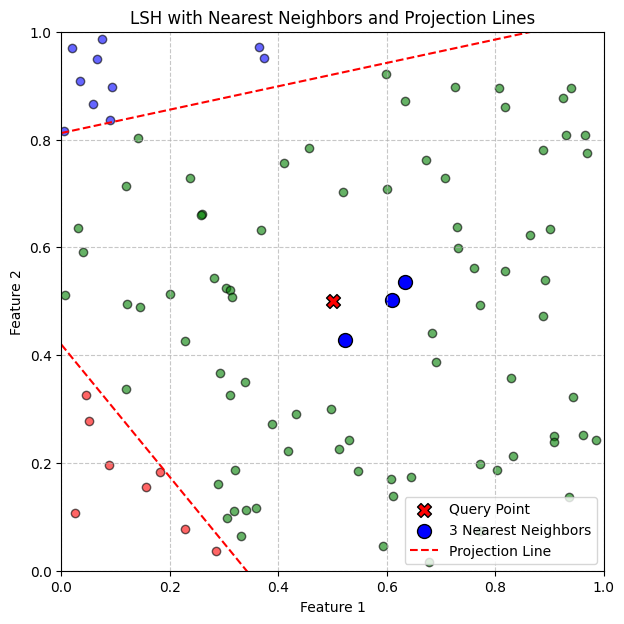

In [26]:
np.random.seed(42)
data = np.random.rand(100, 2)
lsh = LSH(data, num_proj=2)
visualize_kdtree(lsh, data, np.array([0.5, 0.5]), 3)

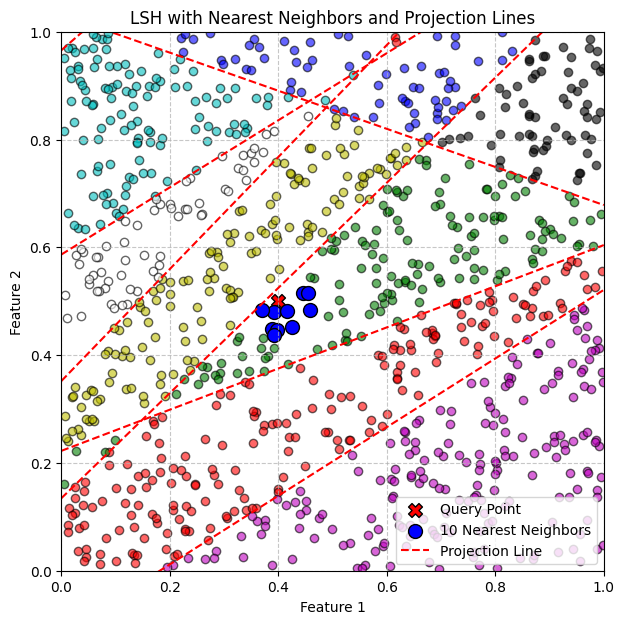

In [27]:
np.random.seed(42)
data = np.random.rand(1000, 2)
lsh = LSH(data, num_proj=10)
visualize_kdtree(lsh, data, np.array([0.4, 0.5]), 10)

## Naive KNN

### Implementation

In [28]:
class KNN:
	def __init__(self, data):
		self.data = data
	
	def query(self, x, k=1):
		distances = np.linalg.norm(self.data - x, axis=1)
		idx = np.argsort(distances)[:k]
		distances.sort()
		return distances[:k], idx

### Visualisation

In [29]:
def visualize_knn(model, data, q, k):
	plt.figure(figsize=(7, 7))
	plt.scatter(data[:, 0], data[:, 1], label='Data points')
	plt.scatter(q[0], q[1], color='red', label='Query Point', edgecolor='k', s=100, marker='X')
	
	dist, idx = model.query(q, k)
	plt.scatter(data[idx, 0], data[idx, 1], color='blue', label=f'{k} Nearest Neighbors', edgecolor='k', s=100)

	plt.xlabel('Feature 1')
	plt.ylabel('Feature 2')
	plt.title('KNN with Nearest Neighbors')
	plt.xlim(0, 1)
	plt.ylim(0, 1)
	plt.legend()
	plt.grid(True, linestyle='--', alpha=0.7)
	plt.show()

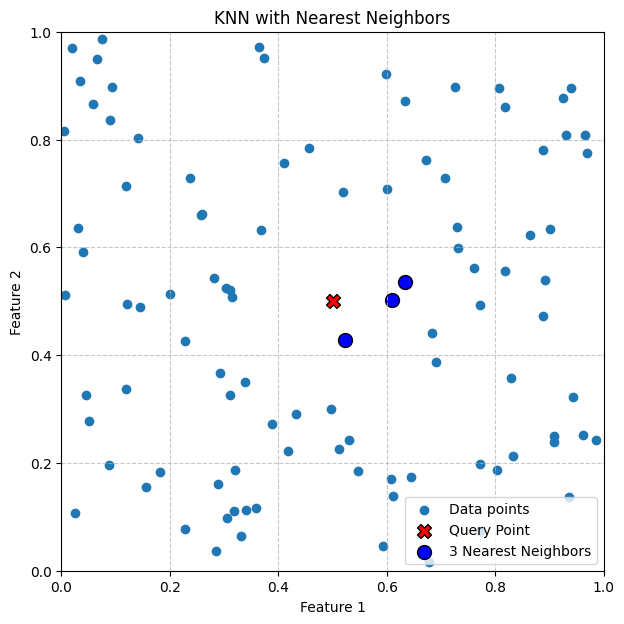

In [30]:
np.random.seed(42)
data = np.random.rand(100, 2)
knn = KNN(data)
visualize_knn(knn, data, np.array([0.5, 0.5]), 3)

## Time and Memory analysis and comparison for KNN, LSH and KD-tree

### Time analysis

#### KNN

KNN takes no build time, but the query time is $O(ND + KN)$ if we use quickselect. But in this implementation we just sort the data and take the first k elements, so the time complexity is $O(ND + N\log N)$.

#### LSH

LSH takes $O(PND)$ time to build the hash table (we assume that D = d + 1) and we store these hashes in a dictionary which takes $O(1)$ armotized time to access and update so the total time is $O(PND)$ to build.

For querying, we calculate the hash of the query point and then we search the hash table for the hash this $O(PD)$ time. We then apply simple KNN on the given cluster which takes $O(nD + n \log n)$ time. So the total time is $O(PD + nD + n \log n)$. n is the number of data points in the cluster.

#### KD-tree

KD-tree takes $O(N \log^2N)$ time to build because we sort this array at every level of the tree. 

For querying, if d is the depth of the tree, then the time complexity is $O(d + nD + n \log n)$. The upper bound of d is $O(\log n)$ so the time complexity is $O(\log N + nD + n \log n)$. n is the number of data points in the leaf node.

### Memory analysis

#### KNN

KNN takes $O(ND)$ memory to store the data. Other than that it take $O(N)$ memory to store the distances.

#### LSH

LSH takes $O(PD + ND)$ memory to store the hash table and clusters.

For querying, we calculate the hash of the query which takes $O(P)$ memory. We then apply simple KNN on the given cluster which takes $O(nD + n)$ memory. So the total memory is $O(P + nD + n)$.

#### KD-tree

KD-tree the number of nodes in the tree is O(2 * N) and the depth of the tree is $O(\log N)$ so the total memory is $O(N + N \log N)$. For querying, the memory taken is simply $O(n + n \log N)$.

In [ ]:
np.random.seed(157)

N_vals = [10, 100, 1000, 10000]
D_vals = [2, 5, 10, 100, 500, 1000]
K_vals = [1, 3, 5, 10, 15, 20]
models = [KNN, LSH, KDTree]
iter = 10

performance = pd.DataFrame(columns=['Model', 'N', 'D', 'K', 'Training Time', 'Testing Time', 'Training Memory', 'Testing Memory'])
loader = tqdm(total=len(N_vals) * len(D_vals) * len(K_vals) * len(models) * iter)

for N in N_vals:
    for D in D_vals:
        for K in K_vals:
            training_times = {}
            testing_times = {}
            training_memories = {}
            testing_memories = {}
            
            for _ in range(iter):
                data = np.random.rand(N, D)
                q = np.random.rand(D)
                for model_cls in models:
                    loader.update(1)

                    tracemalloc.start()
                    training_start = time.process_time()
                    model = model_cls(data)
                    training_end = time.process_time()
                    training_memory = tracemalloc.get_traced_memory()[1]
                    tracemalloc.stop()

                    tracemalloc.start()
                    testing_start = time.process_time()
                    model.query(q, K)
                    testing_end = time.process_time()
                    testing_memory = tracemalloc.get_traced_memory()[1]
                    tracemalloc.stop()

                    if model_cls not in training_times:
                        training_times[model_cls] = []
                        testing_times[model_cls] = []
                        training_memories[model_cls] = []
                        testing_memories[model_cls] = []
                    training_times[model_cls].append(training_end - training_start)
                    testing_times[model_cls].append(testing_end - testing_start)
                    training_memories[model_cls].append(training_memory)
                    testing_memories[model_cls].append(testing_memory)

            for model_cls in models:
                performance = performance._append({
                    'Model': model_cls.__name__,
                    'N': N,
                    'D': D,
                    'K': K,
                    'Training Time': np.mean(training_times[model_cls]),
                    'Testing Time': np.mean(testing_times[model_cls]),
                    'Training Memory': np.mean(training_memories[model_cls]),
                    'Testing Memory': np.mean(testing_memories[model_cls])
                }, ignore_index=True)

loader.close()

  0%|          | 0/4320 [00:00<?, ?it/s]/tmp/ipykernel_30/2879063801.py:57: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  performance = performance._append({
100%|██████████| 4320/4320 [11:51<00:00,  6.07it/s]  


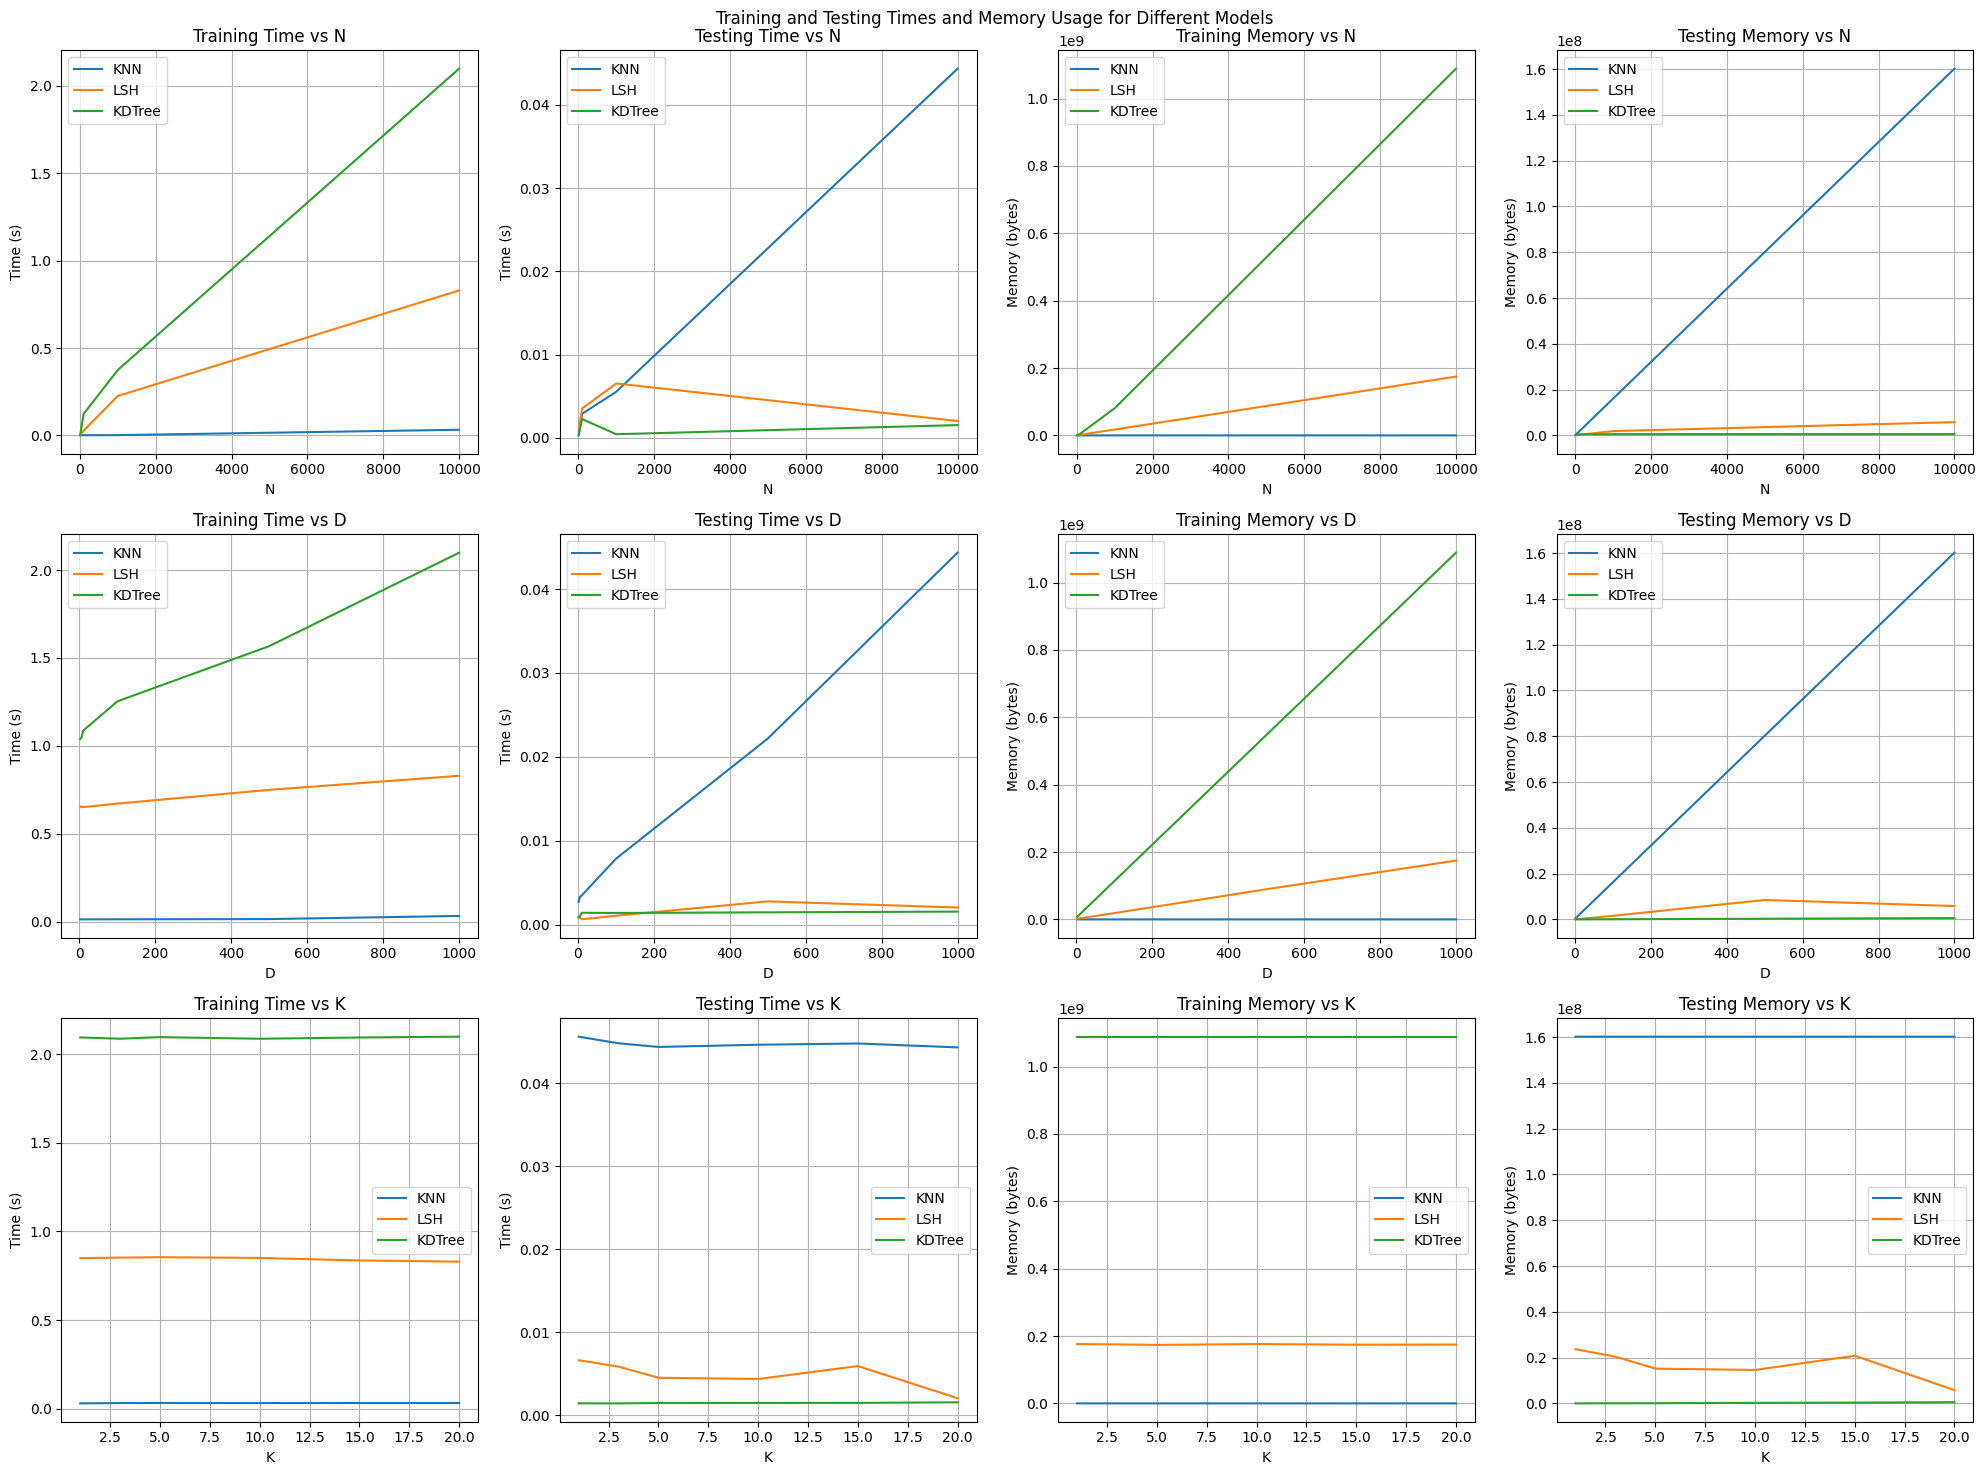

In [32]:
fig, axs = plt.subplots(3, 4, figsize=(20, 15))
fig.suptitle('Training and Testing Times and Memory Usage for Different Models')

for i, (var, var_name) in enumerate(zip([N_vals, D_vals, K_vals], ['N', 'D', 'K'])):
    for model_cls, model_name in zip(models, ['KNN', 'LSH', 'KDTree']):
        model_times = performance[performance['Model'] == model_name]
        if var_name != 'K':
            model_times = model_times[model_times['K'] == max(K_vals)]
        if var_name != 'D':
            model_times = model_times[model_times['D'] == max(D_vals)]
        if var_name != 'N':
            model_times = model_times[model_times['N'] == max(N_vals)]
        
        # Plot Training Time
        axs[i, 0].plot(var, model_times['Training Time'], label=model_name)
        axs[i, 0].set_title(f'Training Time vs {var_name}')
        axs[i, 0].set_xlabel(var_name)
        axs[i, 0].set_ylabel('Time (s)')
        axs[i, 0].grid(True)
        axs[i, 0].legend()
  
        # Plot Testing Time
        axs[i, 1].plot(var, model_times['Testing Time'], label=model_name)
        axs[i, 1].set_title(f'Testing Time vs {var_name}')
        axs[i, 1].set_xlabel(var_name)
        axs[i, 1].set_ylabel('Time (s)')
        axs[i, 1].grid(True)
        axs[i, 1].legend()

        # Plot Training Memory
        axs[i, 2].plot(var, model_times['Training Memory'], label=model_name)
        axs[i, 2].set_title(f'Training Memory vs {var_name}')
        axs[i, 2].set_xlabel(var_name)
        axs[i, 2].set_ylabel('Memory (bytes)')
        axs[i, 2].grid(True)
        axs[i, 2].legend()

        # Plot Testing Memory
        axs[i, 3].plot(var, model_times['Testing Memory'], label=model_name)
        axs[i, 3].set_title(f'Testing Memory vs {var_name}')
        axs[i, 3].set_xlabel(var_name)
        axs[i, 3].set_ylabel('Memory (bytes)')
        axs[i, 3].grid(True)
        axs[i, 3].legend()

plt.tight_layout()
plt.show()